In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
print('Scanpy version:', sc.__version__)

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

Scanpy version: 1.9.1


/tmp/ipykernel_3765579/1644390834.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# # Custom functions
# import sys
# sys.path.insert(1, '../src')
from scperturb import *

# Prepare the data

In [3]:
!wget https://zenodo.org/record/7041849/files/DatlingerBock2021.h5ad

--2022-09-29 16:57:01--  https://zenodo.org/record/7041849/files/DatlingerBock2021.h5ad
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33600780 (32M) [application/octet-stream]
Saving to: ‘DatlingerBock2021.h5ad.1’

DatlingerBock2021.h 100%[===================>]  32.04M  41.3MB/s    in 0.8s    

2022-09-29 16:57:09 (41.3 MB/s) - ‘DatlingerBock2021.h5ad.1’ saved [33600780/33600780]



In [4]:
adata = sc.read('DatlingerBock2021.h5ad')
adata

AnnData object with n_obs × n_vars = 39194 × 25904
    obs: 'sample', 'cell_line', 'perturbation', 'perturbation_2', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'perturbation_type', 'perturbation_type_2', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [5]:
if 'processed' in adata.uns.keys():
    print('The dataset is already processed. Skipping processing...')
else:
    adata.layers['counts'] = adata.X.copy()

    # basic qc and pp
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.normalize_per_cell(adata)
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.log1p(adata)

    # high class imbalance
    adata = equal_subsampling(adata, 'perturbation', N_min=50)
    sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    # select HVGs
    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)

    adata.uns['processed'] = True

# E-distance

In [6]:
# pre-compute pairwise pca distances
pwd = pairwise_pca_distances(adata, 'perturbation', obsm_key='X_pca', dist='sqeuclidean', verbose=True)

100%|██████████| 41/41 [00:03<00:00, 13.01it/s]


In [7]:
# Compute E-distances
estats = edist(adata, obs_key='perturbation', obsm_key='X_pca', pwd=pwd, dist='sqeuclidean')

In [8]:
# square matrix, all pairs of perturbations get an e-distance
estats.head()

,control,LAT_2,LCK_2,JUND_2,ZAP70_2,FOS_2,EGR3_2,EGR4_1,PTPN11_2,LAT_1,...,EGR4_2,NFATC1_2,NFATC1_1,RELA_2,NFKB1_1,RELA_1,NFKB2_1,NFAT5_1,NR4A1_2,RUNX2_1
control,0.000000,1.670444,1.056285,0.569198,1.965560,0.394356,0.076373,1.527886,0.711475,2.512003,...,0.418090,2.825603,1.652124,0.078861,0.427440,0.686022,-0.102583,0.258928,-0.069865,0.777721
LAT_2,1.670444,0.000000,0.298560,0.017524,-0.047979,-0.163535,0.605993,3.171256,1.577750,-0.147091,...,1.259721,5.116656,4.783091,1.390328,1.659481,-0.075113,0.292556,0.901398,0.776919,1.515641
LCK_2,1.056285,0.298560,0.000000,0.364594,0.275221,-0.424814,0.029707,1.524808,0.393454,0.172068,...,0.721834,3.370582,2.879835,1.647352,1.537985,0.108125,0.376715,0.623674,0.952039,0.750822
JUND_2,0.569198,0.017524,0.364594,0.000000,0.910914,-0.431430,0.122369,1.554269,1.131193,1.111029,...,-0.036045,3.063303,2.617334,-0.005053,0.092347,0.023742,-0.370664,-0.170893,-0.186754,0.669585
ZAP70_2,1.965560,-0.047979,0.275221,0.910914,0.000000,0.339827,0.778287,3.713330,1.519976,-0.117086,...,1.794481,6.114364,5.459627,2.055435,2.725432,-0.116124,1.051081,1.540266,1.964294,1.750136


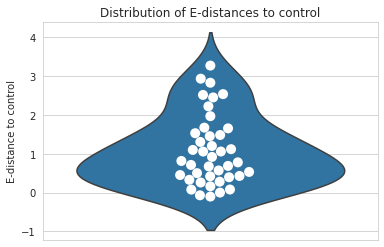

In [36]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['control'], inner=None)
    sns.swarmplot(data=estats.loc['control'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

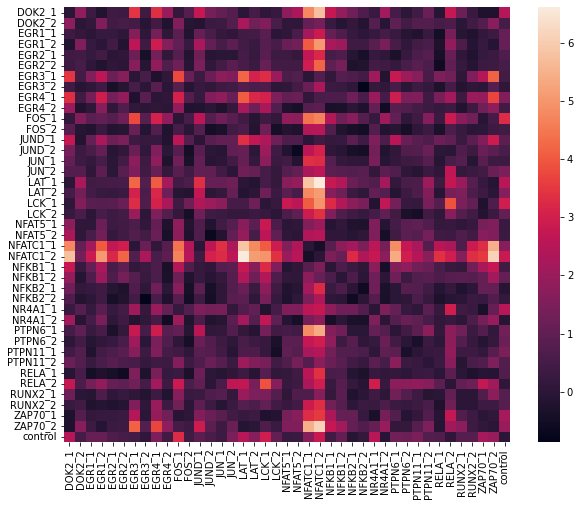

In [41]:
fig, ax = pl.subplots(1,1, figsize=[10,8])
order = estats.sort_index().index
sns.heatmap(estats.loc[order, order])
pl.show()

# E-testing

In [9]:
# e-testing (can be slow)
df = etest(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean', control='control', alpha=0.05, runs=100)

100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


In [11]:
df.head()

,edist,pvalue,significant,pvalue_adj,significant_adj
DOK2_1,2.447436,0.00,True,0.000000,True
DOK2_2,0.500256,0.11,False,0.814698,False
EGR1_1,1.097101,0.01,True,0.237657,False
EGR1_2,1.116779,0.01,True,0.237657,False
EGR2_1,0.673058,0.05,False,0.622646,False


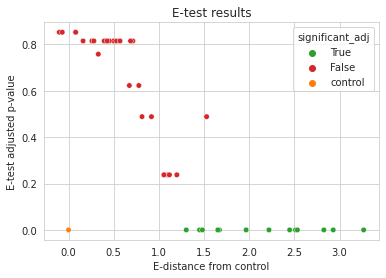

In [74]:
df.loc[df.index=='control', 'significant_adj'] = 'control'
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test adjusted p-value')
pl.show()

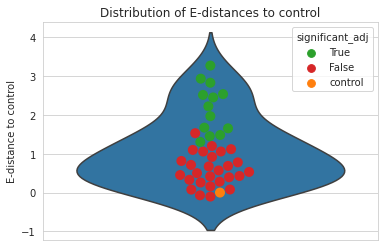

In [65]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=df, y='edist', inner=None)
    sns.swarmplot(data=df, x=[0]*len(df), y='edist', size=10, hue='significant_adj', dodge=False, palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'})
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()